## Transition indicators (TIs)

The present notebook aims to provide exemplary computation of TIs. Therefore, two systems are studied:
1. a linear system (therefore incapable of undergoing critical transitions) to test the presence of false negatives.
2. a nonlinear system representing a 1D double-well that undergoes a critical transition.

First we load the packages and self-written functions:

In [1]:
using DrWatson
@quickactivate "StatisticalEWS"

using LinearAlgebra, BenchmarkTools, RollingFunctions
using Statistics, StatsBase, Random, Distributions
using CairoMakie, DifferentialEquations, FFTW, CUDA

include(srcdir("ews.jl"))
include(srcdir("utils.jl"))
include(srcdir("stattest.jl"))

check_std_endpoint (generic function with 1 method)

#### Model definition

We let both aforementioned models be forced by a user-defined function. In the present case, this is a simple linear drift such that the double-well model is driven out of its original equilibrium (i.e. experiences a transition).

In [2]:
# Deterministic part of linear system.
function f_linear(dx, x, p, t)
    dx[1] = p["λ"] * (x[1] + 1) + forcing(p, t)
end

# Deterministic part of double-well system.
function f_doublewell(dx, x, p, t)
    dx[1] = -x[1]^3 + x[1] + forcing(p, t)
end

# Stochastic part of system for noise.
function g_whitenoise(dx, x, p, t)
    dx[1] = p["σ"]
end

function forcing(p, t)
    return p["α"] * t
end

forcing (generic function with 1 method)

#### Perform simulation

In [3]:
# Define time step, vector and span. IC set for equilibrium of both systems.
dt = 1f-2
t = collect(0f0:dt:10f0)
tspan = extrema(t)
x0 = [-1f0]

pmodel = Dict("σ" => .1f0, "λ" => -1f0, "α" => .1f0)
models = [f_linear, f_doublewell]
labels = ["linear", "doublewell"]
nmodels = length(models)
X = zeros(Float32, nmodels, length(t))

for (f, lbl, i) in zip(models, labels, 1:nmodels)
    prob = SDEProblem(f, g_whitenoise, x0, tspan, pmodel)
    sol = solve(prob, EM(), dt=dt)
    X[i, :] = vcat(sol.u...)
end

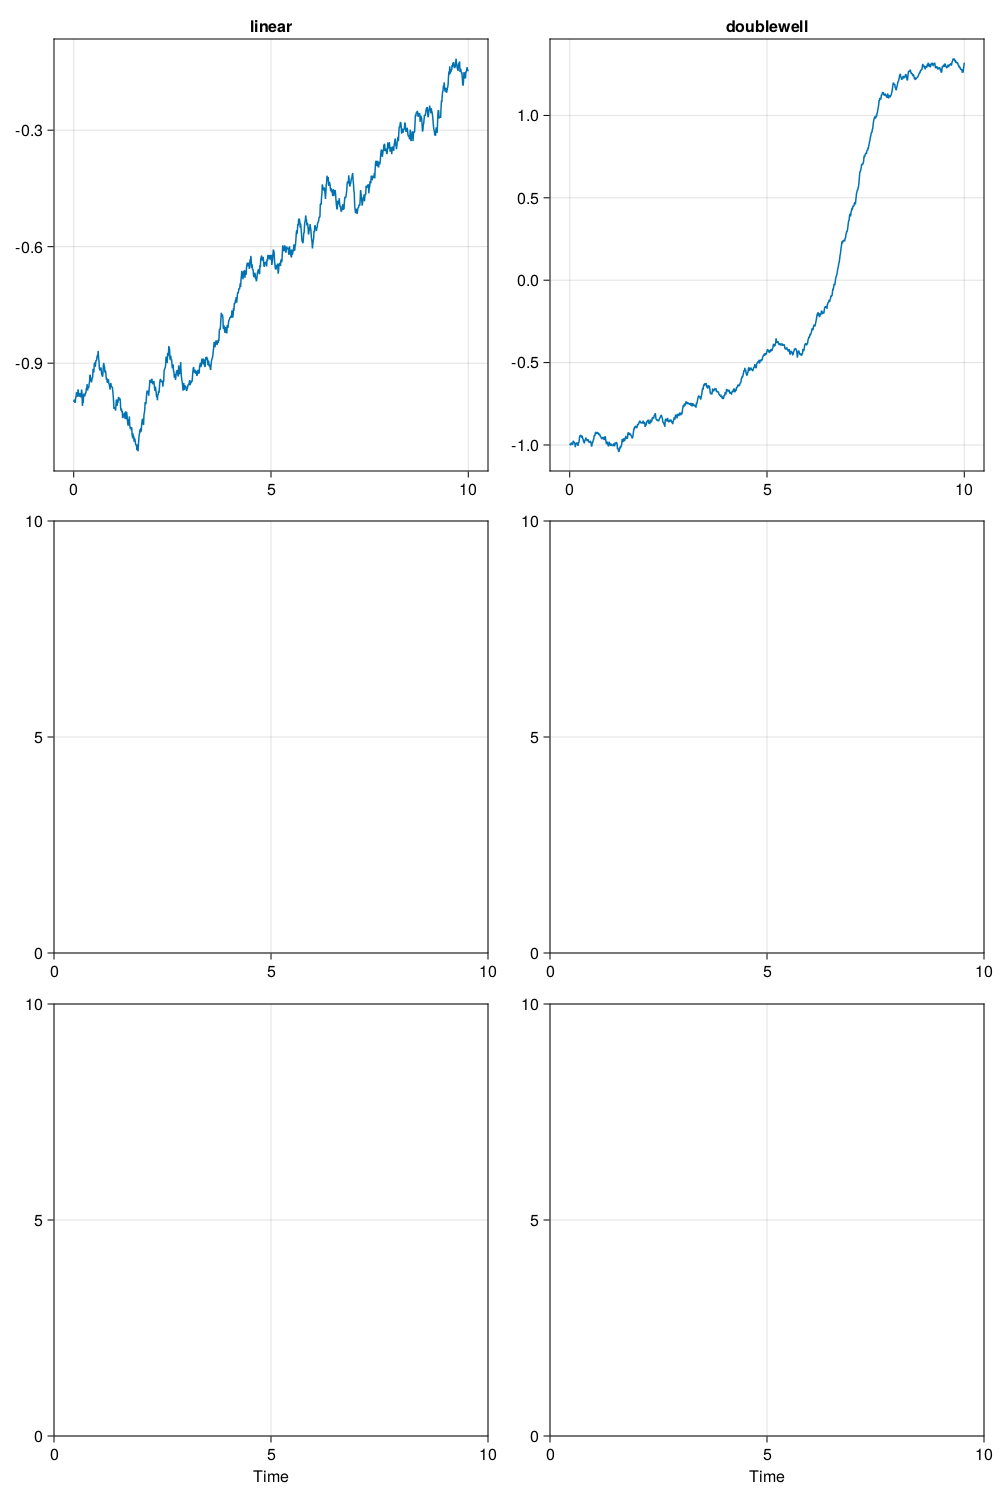

In [4]:
nrows, ncols = 3, 2
fig = Figure( resolution = (1000, 1500) )
axs = [[Axis(
    fig[i,j],
    title = ( i==1 ? labels[j] : " "),
    xlabel = ( i==nrows ? "Time" : " "),
    ) for j in 1:ncols] for i in 1:nrows]

[lines!(axs[1][i], t, X[i, :], label = "data") for i in 1:nmodels]
fig

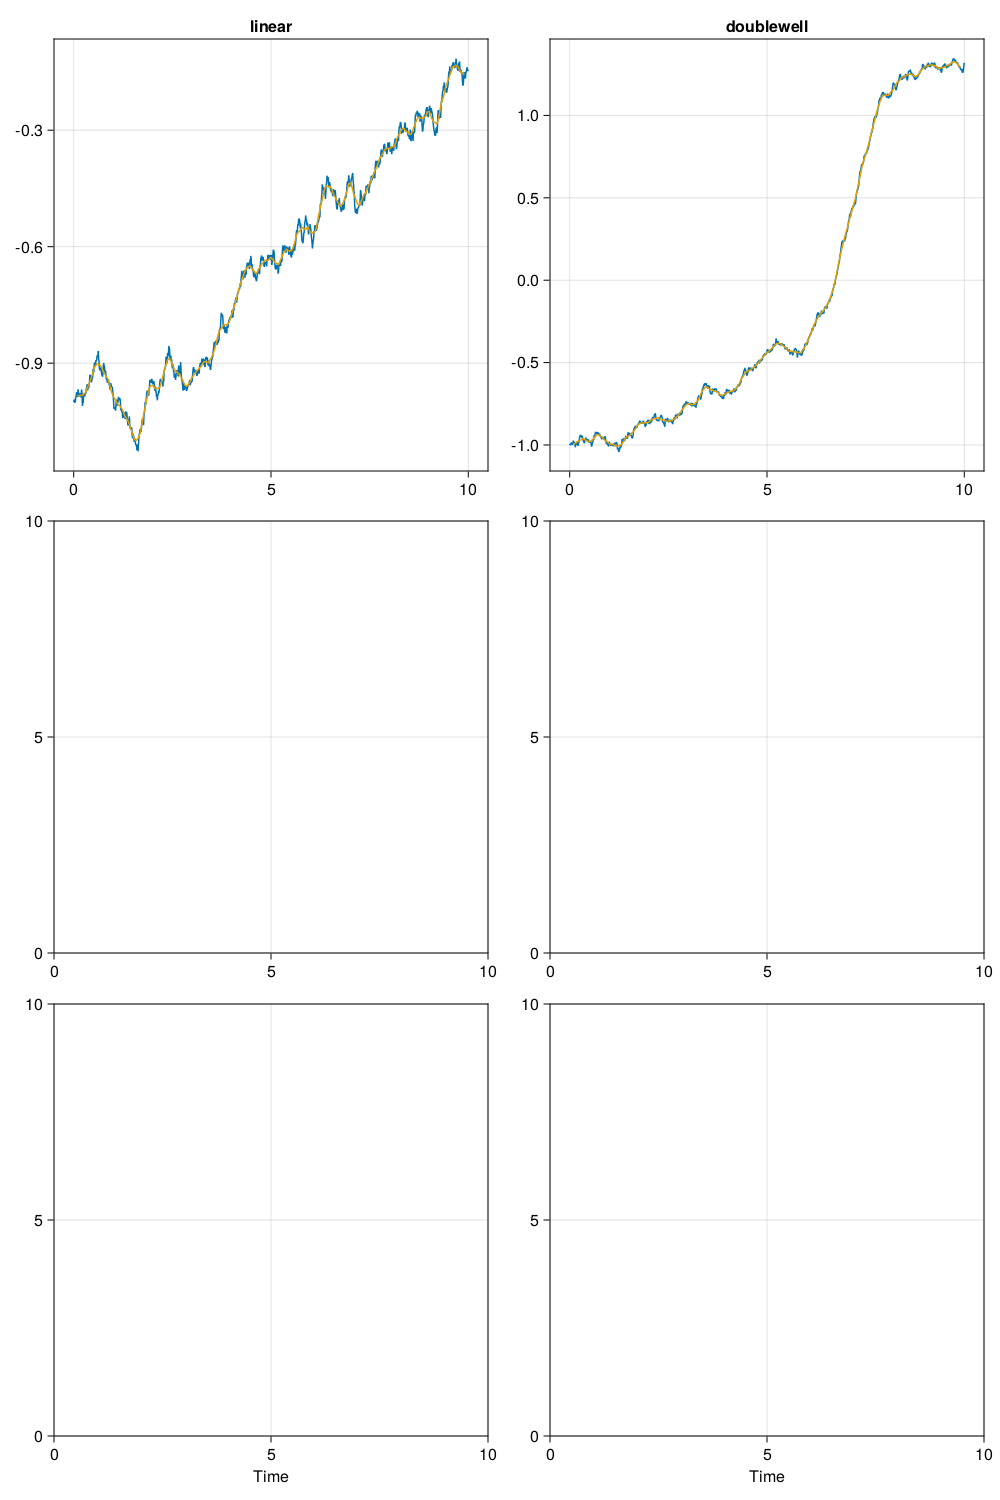

In [5]:
Tsmooth = 0.1       # half-width for smoothing window .
Tindctr = 0.5       # half-width for computation of indicator.
Tsignif = 1         # half-width for computation of indicator significance.
Tstride = 0.2       # stride for computation of indicator.
T = [dt, Tsmooth, Tindctr, Tsignif, Tstride]
N = get_step.(T[2:end], dt)
pwin = WindowingParams(T..., N...)
window = centered_window
trend = gettrend_rollmean

Xtrend = mapslices( x_ -> trend(x_, pwin.Nsmooth), X; dims=2 )
[lines!(axs[1][i], t, Xtrend[i, :], label = "trend") for i in 1:nmodels]
fig

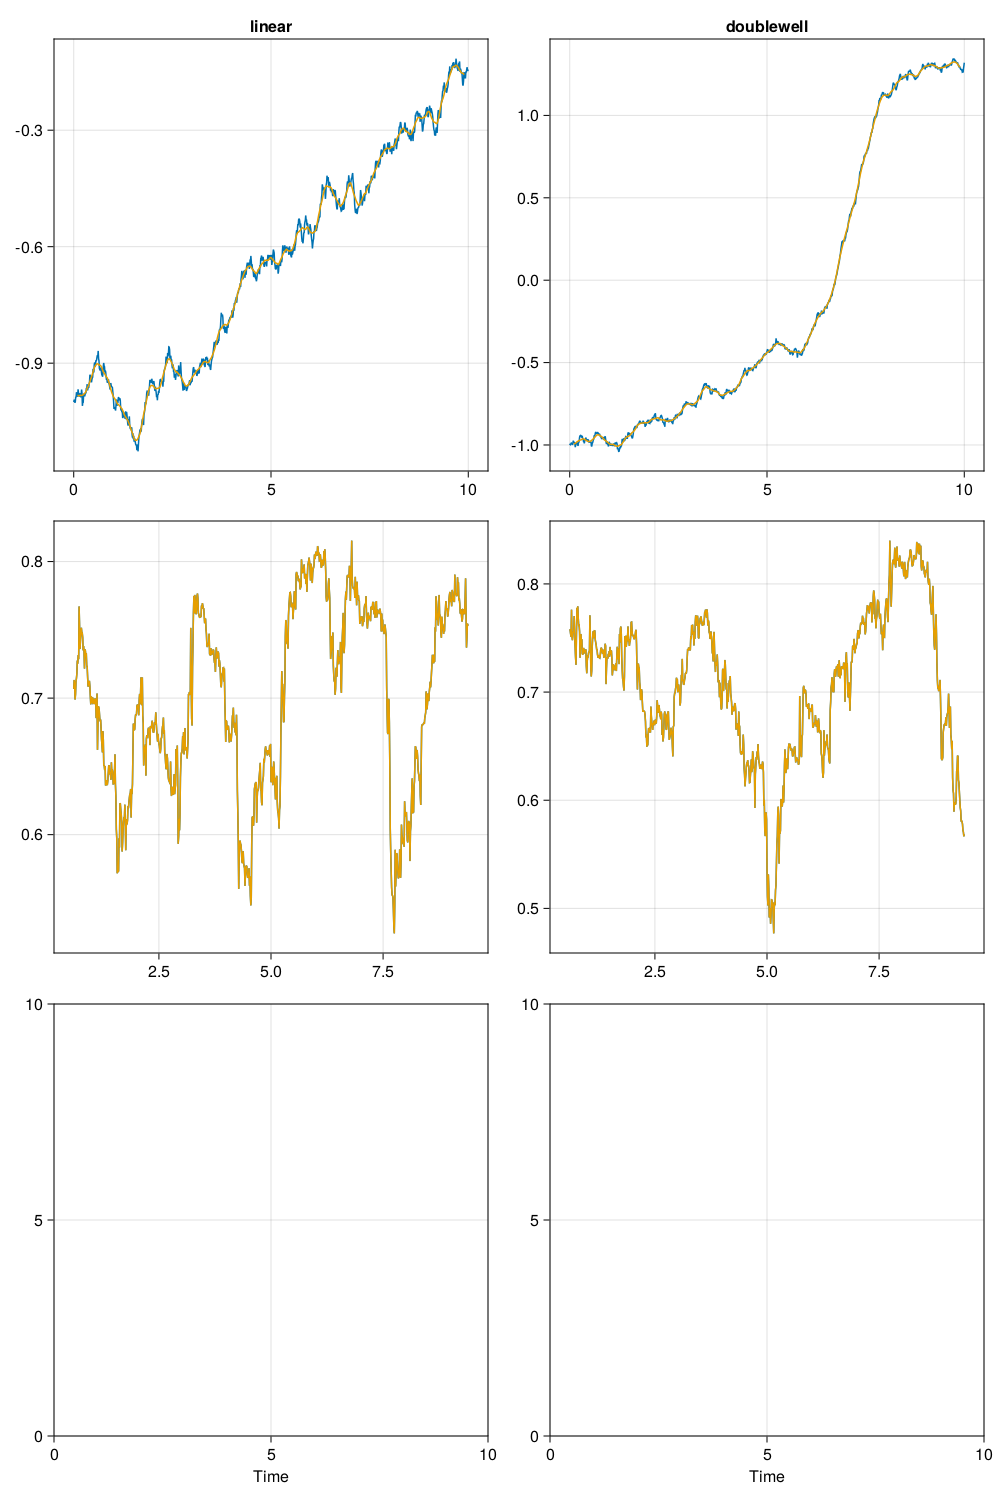

In [16]:
Xres_cpu = X .- Xtrend
Xres_gpu = CUDA.CuArray( Xres_cpu )

TI_cpu = slide_estimator( Xres_cpu, pwin.Nindctr, ar1_whitenoise )
[lines!(axs[2][j], t, TI_cpu[j, :], label = "ar1_cpu") for j in 1:ncols]
fig

#### Benchmarking

In [13]:
TI_gpu = ar1_whitenoise( Xres_gpu, pwin )

2×1000 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [8]:
@benchmark slide_estimator( Xres_cpu, pwin.Nindctr, ar1_whitenoise )

BenchmarkTools.Trial: 1590 samples with 1 evaluation.
 Range (min … max):  855.477 μs … 30.386 ms  ┊ GC (min … max):  0.00% … 86.67%
 Time  (median):       2.518 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):     3.135 ms ±  3.854 ms  ┊ GC (mean ± σ):  20.93% ± 15.23%

  ▆▂▄██▇▅▃▁                                                     
  █████████▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▅▆▆▄▅▅▆▅ █
  855 μs        Histogram: log(frequency) by time        25 ms <

 Memory estimate: 7.74 MiB, allocs estimate: 9060.

In [9]:
@benchmark ar1_whitenoise( Xres_gpu, pwin )

BenchmarkTools.Trial: 415 samples with 1 evaluation.
 Range (min … max):   8.001 ms … 33.250 ms  ┊ GC (min … max): 0.00% …  0.00%
 Time  (median):     11.578 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.046 ms ±  3.208 ms  ┊ GC (mean ± σ):  4.66% ± 10.47%

      ▁▁  ▅▄█▂▂█▆█▅▃                                           
  ▄▄▅▅███████████████▇▆▄▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▃▃▁▂▃▁▃▃▃▂▂▁▂▂▁▂▁▃ ▄
  8 ms            Histogram: frequency by time        24.3 ms <

 Memory estimate: 15.26 MiB, allocs estimate: 442091.